# Building model to classify 10 different ID cards
We want to build a sequential keras model, using tensorflow.

## Installing Dependencies

In [311]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from keras import layers
from keras.models import Sequential
from keras import regularizers


## Load images
We need to put the images of each class in seperate folder with appropriate name in `data` directory.


Using 20% of images as *test* set and the remaining 80% as *train* set. Resizing the images to `img_height`, `img_width`.
Also exporting `csv` file to use in backend app.

Found 1000 files belonging to 10 classes.
['alb_id', 'aze_passport', 'esp_id', 'est_id', 'fin_id', 'grc_passport', 'lva_passport', 'rus_internalpassport', 'srb_passport', 'svk_id']


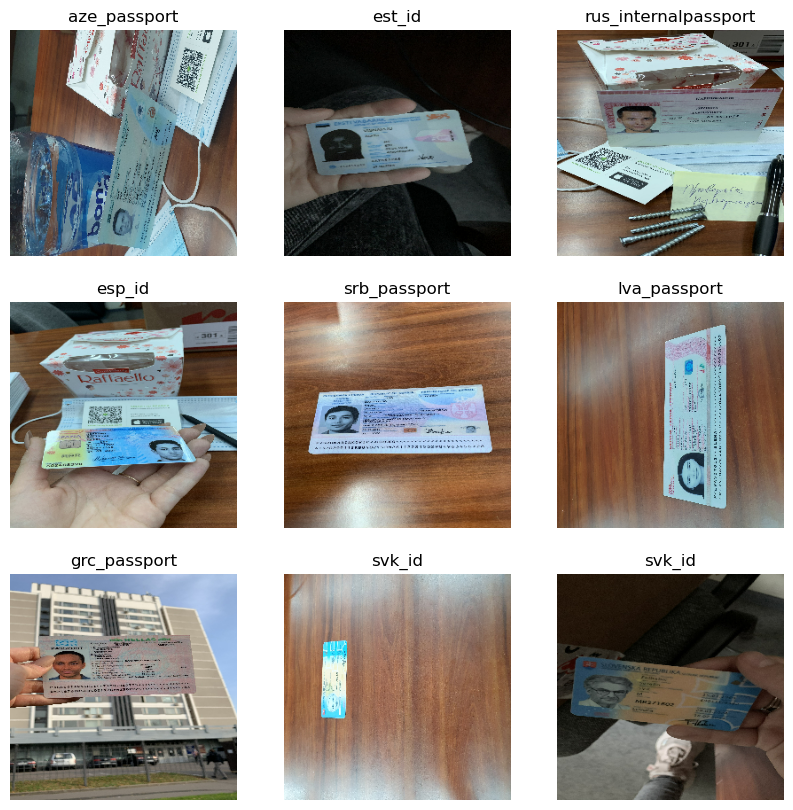

In [312]:
batch_size = 25
img_height = 256
img_width = 256

data = tf.keras.utils.image_dataset_from_directory('data', image_size=(img_height, img_width) , batch_size=batch_size)
class_names = data.class_names
print(class_names)
with open('backend/model/class_names.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write each class name on a new line
    for name in class_names:
        writer.writerow([name])
num_classes = len(class_names)

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")





## Create train, validation and test sets

In [313]:
data = data.map(lambda x,y: (x/255, y))
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


## Building the model


In [315]:
model = Sequential()

model.add(layers.Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5), input_shape=(img_height, img_width, 3)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 256, 256, 64)      256       
                                                                 
 dropout_35 (Dropout)        (None, 256, 256, 64)      0         
                                                                 
 conv2d_243 (Conv2D)         (None, 256, 256, 16)      9232      
                                                                 
 max_pooling2d_243 (MaxPool  (None, 128, 128, 16)      0         
 ing2D)                                                          
                                                                 
 conv2d_244 (Conv2D)         (None, 128, 128, 64)      9280      
                                                                 
 max_pooling2d_244 (MaxPool  (None, 64, 64, 64)        0         
 ing2D)                                              

In [316]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
epochs = 20
history = model.fit(train, epochs=epochs, validation_data=val)


Epoch 1/20


28/28 [==============================] - 42s 1s/step - loss: 2.7330 - accuracy: 0.0914 - val_loss: 2.5651 - val_accuracy: 0.1250
Epoch 2/20
28/28 [==============================] - 40s 1s/step - loss: 2.4983 - accuracy: 0.1200 - val_loss: 2.4558 - val_accuracy: 0.1250
Epoch 3/20
28/28 [==============================] - 42s 1s/step - loss: 2.4096 - accuracy: 0.1286 - val_loss: 2.3810 - val_accuracy: 0.1550
Epoch 4/20
28/28 [==============================] - 44s 1s/step - loss: 2.3216 - accuracy: 0.1643 - val_loss: 2.3234 - val_accuracy: 0.1500
Epoch 5/20
28/28 [==============================] - 44s 1s/step - loss: 2.2637 - accuracy: 0.1886 - val_loss: 2.2443 - val_accuracy: 0.2000
Epoch 6/20
28/28 [==============================] - 45s 2s/step - loss: 2.1206 - accuracy: 0.2800 - val_loss: 2.1614 - val_accuracy: 0.2350
Epoch 7/20
28/28 [==============================] - 48s 2s/step - loss: 1.7806 - accuracy: 0.4129 - val_loss: 1.9261 - val_accuracy: 0.3850
Epoch 8/20
28/28 [=============

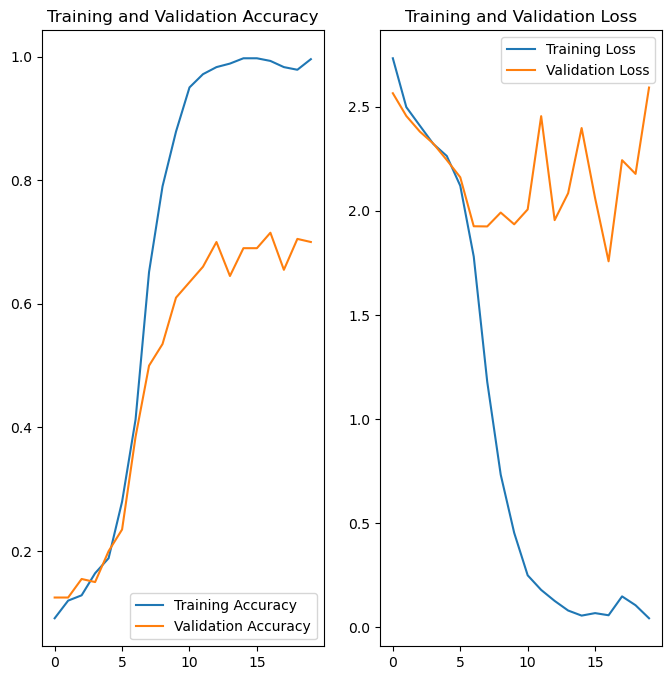

In [317]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



## Evaluate

In [321]:
import tensorflow_addons as tfa
def success_rate(data_set):
    success_rate = []
    for batch in data_set.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        pred_index = []
        for yh in yhat:
            pred_index.append(yh.argmax(axis=-1))
        correct_pred = 0
        for i in range(len(y)):
            if y[i] == pred_index[i]:
                correct_pred += 1
        success_rate.append(correct_pred/len(y))

    average_success_rate = np.sum(success_rate)/len(success_rate)
    return average_success_rate



def cohen_kappa(data_set):
    metric = tfa.metrics.CohenKappa(num_classes=num_classes, sparse_labels=True)
    for batch in data_set.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        # print(X)
        pred_index = []
        for yh in yhat:
            pred_index.append(yh.argmax(axis=-1))
        metric.update_state(y , pred_index)
    return metric.result().numpy()

In [325]:
sr = success_rate(train)
ck = cohen_kappa(train)
print("Training success rate: ", sr)
print("Training cohens kappa: ", ck)

1/1 [==============================] - 0s 298ms/step
Training success rate:  1.0
Training cohens kappa:  0.9952368


In [323]:
sr = success_rate(val)
ck = cohen_kappa(val)
print("Validation success rate: ", sr)
print("Validation cohens kappa: ", ck)

1/1 [==============================] - 0s 165ms/step
Validation success rate:  0.69
Validation cohens kappa:  0.7218049


In [319]:
sr = success_rate(test)
ck = cohen_kappa(test)
print("Test success rate: ", sr)
print("Test cohens kappa: ", ck)

1/1 [==============================] - 0s 155ms/step
Test success rate:  0.65
Test cohens kappa:  0.6317376


## Save

In [324]:

model.save('backend/model/id-classification.h5')


/Users/anosrati/code/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
